In [ ]:
#Resources used:
#https://vtiya.medium.com/the-difference-between-bert-uncased-and-cased-ec25e632b426#:~:text=%E2%80%9CUncased%E2%80%9D%3A%20Characters%20which%20are,difference%20between%20english%20and%20English.
#https://huggingface.co/google-bert/bert-base-cased
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
#https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
#https://medium.com/@shaikhrayyan123/a-comprehensive-guide-to-understanding-bert-from-beginners-to-advanced-2379699e2b51
#https://medium.com/@heyamit10/fine-tuning-bert-for-classification-a-practical-guide-b8c1c56f252c
#https://yashuseth.wordpress.com/2019/06/12/bert-explained-faqs-understand-bert-working/
#https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertModel
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/


#For building model
#https://www.sabrepc.com/blog/Deep-Learning-and-AI/text-classification-with-bert?srsltid=AfmBOopz30a90TLa1G6JClyLTGzmcG9l3Lmnd2irr6tG9qp576IHSG7g

#Distilbert
#https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f/


# Dataset 1

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/spam-emails")

print("Path to dataset files:", path)


# Define dataset path
dataset_folder = path  # This is the downloaded dataset folder

# List files in the dataset folder
files = os.listdir(dataset_folder)
print("Dataset files:", files)

# Load a CSV file into pandas
csv_file = os.path.join(dataset_folder, files[0]) # Replace with actual file name
df = pd.read_csv(csv_file, encoding='ISO-8859-1')


# utilizing 2 differnet datasets
df_1 = df
# cleaning df_1
# Rename relevant columns

df_1 = df_1[['Category', 'Message']]
df_1.columns = ['label', 'text']

# Convert labels to binary (1 for spam, 0 for non-spam)
df_1['label'] = df_1['label'].map({'ham': 0, 'spam': 1})

# Display first few rows
df_1

# Remove multiple spaces
df_1['text'] = df_1['text'].str.strip()
df_1['text'] = df_1['text'].str.replace(r'\s+', ' ', regex=True)
# fix encoding issues since there are random symbols such as: â, Âº, etc.
df_1['text'] = df_1['text'].str.encode('ascii', 'ignore').str.decode('utf-8')

# removing number placeholders (&lt;#&gt)
df_1['text'] = df_1['text'].str.replace(r'&lt;#&gt;', '[NUMBER]', regex=True)

# removing URL placeholders (&lt;URL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;URL&gt;', '[URL]', regex=True)

# removing decimal placeholders (&lt;DECIMAL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;DECIMAL&gt;', '[DECIMAL]', regex=True)

# removing time placeholders (&lt;TIME&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;TIME&gt;', '[TIME]', regex=True)

# removing email placeholders (&lt;EMAIL&gt;)
df_1['text'] = df_1['text'].str.replace(r'&lt;EMAIL&gt;', '[EMAIL]', regex=True)

# Remove all occurrences of '&gt;' (greater-than sign encoding)
df_1['text'] = df_1['text'].str.replace(r'&gt;', '', regex=True)

df_1

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\abdallahwagih\spam-emails\versions\1
Dataset files: ['spam.csv']


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


In [ ]:
#Defining BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
bert = DistilBertModel.from_pretrained("distilbert-base-cased", num_labels=2)

237


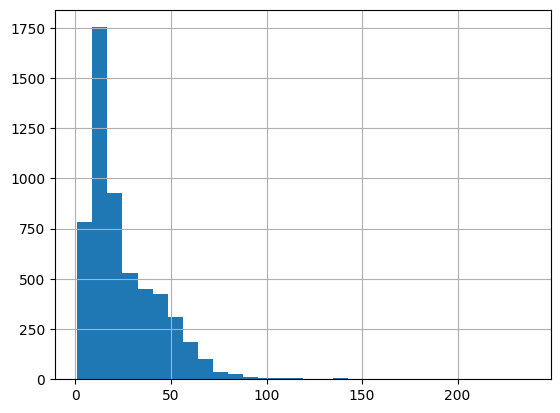

In [ ]:
#Resources used: https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch
#Find the max sequence length

labels = df_1.iloc[:, 0].values  # Extract the first column (labels)
texts = df_1.iloc[:, 1].values   # Extract the second column (text)

def find_max_squence_length(texts):
  seq_len = [len(tokenizer.tokenize(i)) for i in texts]
  pd.Series(seq_len).hist(bins = 30)
  max_seq_len = max(seq_len)
  if max_seq_len > 512:
    max_seq_len = 512
  return(max_seq_len)

max_length = find_max_squence_length(texts)
print(max_length)

In [ ]:
#Tokenizing function
def tokenize_and_return_chunks_new(text,label, max_length):
  chunksize = max_length
  chunks = [text[i:i+chunksize] for i in range(0, len(text), chunksize)]
  chunks_input =[]
  for i in chunks:
    embeddings = tokenizer(i, return_tensors='pt', max_length = max_length, padding = 'max_length', truncation = True)
    chunks_input.append((embeddings, label))
  return chunks_input

In [ ]:
#Prepare tokenized texts
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
# Get input_ids, token_type_ids, attention_masks, nth chunk, labels of each chunk of text (not exceeding 510 tokens)

def get_embeddings_and_labels(texts,labels, max_length):
  text_chunks_labels1 = []
  text_embeddings = []
  chunk_num = []
  num = 0
  for i in range(len(texts)):
    for j in tokenize_and_return_chunks_new(texts[i],labels[i],max_length):
      text_embeddings.append(j[0])
      text_chunks_labels1.append(j[1])
      chunk_num.append(num)
    num+=1
  return (text_chunks_labels1,text_embeddings, chunk_num)

text_chunks_labels1, text_embeddings, chunk_num = get_embeddings_and_labels(texts,labels,max_length)


In [ ]:
print(len(text_embeddings))

5659


In [ ]:
def featuresgetter(text_embeddings, bert = bert):
    features = []
    count = 0
    for i in text_embeddings:
      with torch.no_grad():
        features.append(bert(**i).last_hidden_state[:,0,:])


    return features

In [ ]:
training_validation_text_embeddings = text_embeddings[:5093]
training_validation_chunks_labels = text_chunks_labels1[:5093]
features = featuresgetter(training_validation_text_embeddings)


#features = featuresgetter(training_validation_text_embeddings)




In [ ]:
print(len(features))

5093


In [ ]:
#Splitting training and validation features/labels
training_features = features[:4527]
validation_features = features[4527:5093]
labels = [torch.tensor(item).unsqueeze(0) for item in training_validation_chunks_labels]
chunknum = [torch.tensor(item) for item in chunk_num[:5093]]
training_labels = labels[:4527]
validation_labels = labels[4527:5093]
training_chunknum = labels[:4527]
validation_chunknum = labels[4527:5093]


In [ ]:
print(len(training_features))

4527


In [ ]:
#Test Features
test_text_embeddings = text_embeddings[5093:]
test_chunks_labels = text_chunks_labels1[5093:]
test_features = featuresgetter(test_text_embeddings)

In [ ]:
#Getting test features
test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_chunknum = [torch.tensor(item) for item in chunk_num[5093:]]

In [ ]:
#Loading data using https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00/
#Make batches
class dataset(Dataset):
    def __init__(self, features, labels, chunknum):
        """
        Args:
            data (list or torch.Tensor): List of input data or a PyTorch tensor.
            labels (list or torch.Tensor): List of labels or a PyTorch tensor.
        """
        self.features = features
        self.labels = labels
        self.chunknum = chunknum

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieves a sample from the dataset at the given index."""
        sample = self.features[idx]
        label = self.labels[idx]
        chunknum = self.chunknum[idx]

        return sample, label, chunknum

train_set = dataset(training_features, training_labels, training_chunknum)
validation_set = dataset(validation_features, validation_labels, validation_chunknum)





In [ ]:
#Resources Used: Lab 2
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = (0,1)
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch, num):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, num)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels, _ = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        predictions = (torch.sigmoid(outputs) > 0.5).long()
        mismatches = (predictions!= labels)
        total_err += int(mismatches.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def evaluate_test(net, loader, criterion):
    predictions_list = []
    true_labels_list = []
    chunk_num_list = []
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels, chunknum = data
        labels = normalize_label(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        predictions = (torch.sigmoid(outputs) > 0.5).long()
        predictions_list.extend([x[0] for x in predictions.tolist()])
        true_labels_list.extend([x[0] for x in labels.tolist()])
        chunk_num_list.extend([tensor.item() for tensor in chunknum])
        # Calculate TP, TN, FP, FN
        mismatches = (predictions!= labels)
        total_err += int(mismatches.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    if not (len(predictions_list) == len(true_labels_list) == len(chunk_num_list)):
      raise ValueError("All input lists must have the same length")

    # Get unique chunk numbers
    unique_chunks = sorted(set(chunk_num_list))

    # Initialize results dictionary and lists
    results = {}
    chunk_majority_predictions = []
    chunk_true_labels = []

    # Process each chunk
    for chunk in unique_chunks:
        # Get indices for the current chunk
        indices = [i for i, num in enumerate(chunk_num_list) if num == chunk]

        # Get the true label for this chunk (should be the same for all indices in the chunk)
        chunk_true_label = true_labels_list[indices[0]]

        # Verify that all true labels in this chunk are the same
        if not all(true_labels_list[i] == chunk_true_label for i in indices):
            raise ValueError(f"True labels are not consistent within chunk {chunk}")

        # Get predictions for this chunk
        chunk_pred_labels = [predictions_list[i] for i in indices]

        # Determine majority prediction (1 if more 1s than 0s, otherwise 0)
        ones_count = sum(1 for pred in chunk_pred_labels if pred == 1)
        majority_prediction = 1 if ones_count > len(chunk_pred_labels) / 2 else 0

        # Count how many predictions match the true label for this chunk
        matches = sum(1 for pred in chunk_pred_labels if pred == chunk_true_label)

        # Total items in this chunk
        total = len(indices)

        # Check if matches exceed half of the total
        results[chunk] = 1 if matches > total / 2 else 0

        # Add to our result lists
        chunk_majority_predictions.append(majority_prediction)
        chunk_true_labels.append(chunk_true_label)





    return err, loss, chunk_majority_predictions, chunk_true_labels

###############################################################################
# Training Curve
def plot_training_curve(path, num):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title(f"Train vs Validation Error For Dataset {num}")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.savefig('{}_error.png'.format(path))
    plt.show()
    plt.title(f"Train vs Validation Loss For Dataset{num}")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('{}_loss.png'.format(path))
    plt.show()


def find_val(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_err)
    mean_val_err = val_err[-1]
    mean_val_loss = val_loss[-1]
    print(f"The final validation error and loss for {path} is {mean_val_err} and {mean_val_loss} respectively")

In [ ]:
# Resources Used: Lab 2
def train(net, train_set, validation_set, data_setnum, batch_size=64, learning_rate=0.01, num_epochs=100):
    # Load data
    validation_loader = DataLoader(validation_set, batch_size= batch_size, shuffle = True)
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels, _ = data
            #To Enable GPU Usage
            if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            predictions = ((outputs) > 0.0).long()
            mismatches = (predictions!= labels)
            total_train_err += int(mismatches.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, validation_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch, data_setnum)
        torch.save(net.state_dict(), model_path)
    print(model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
#Defining the model and methods
class SModel(nn.Module):
    def __init__(self, kernel1 = 10, kernel2 = 15):
        super(SModel, self).__init__()
        self.name = "SpamClassifier"
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,1)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
#Defining spam classifier
spam_classifier = SModel()

In [ ]:
train(spam_classifier, train_set, validation_set, 1)

Epoch 1: Train err: 0.13386348575215373, Train loss: 0.3750616752765548 |Validation err: 0.12897526501766785, Validation loss: 0.2493705285920037
Epoch 2: Train err: 0.06472277446432516, Train loss: 0.15183896398250485 |Validation err: 0.028268551236749116, Validation loss: 0.09614213721619712
Epoch 3: Train err: 0.023194168323392977, Train loss: 0.07100634473625203 |Validation err: 0.0176678445229682, Validation loss: 0.06294216008649932
Epoch 4: Train err: 0.019218025182239893, Train loss: 0.055460131045063615 |Validation err: 0.015901060070671377, Validation loss: 0.05105215166178015
Epoch 5: Train err: 0.01480008835873647, Train loss: 0.04880067074513981 |Validation err: 0.015901060070671377, Validation loss: 0.04937188285920355
Epoch 6: Train err: 0.013474707311685442, Train loss: 0.044535604928633274 |Validation err: 0.015901060070671377, Validation loss: 0.044865590002801686
Epoch 7: Train err: 0.012591119946984758, Train loss: 0.04035642139718566 |Validation err: 0.014134275618

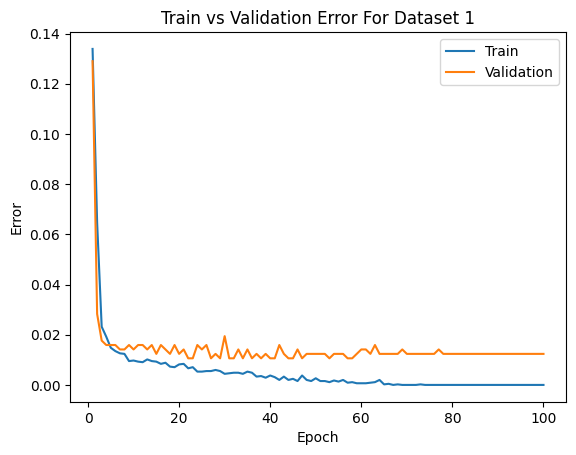

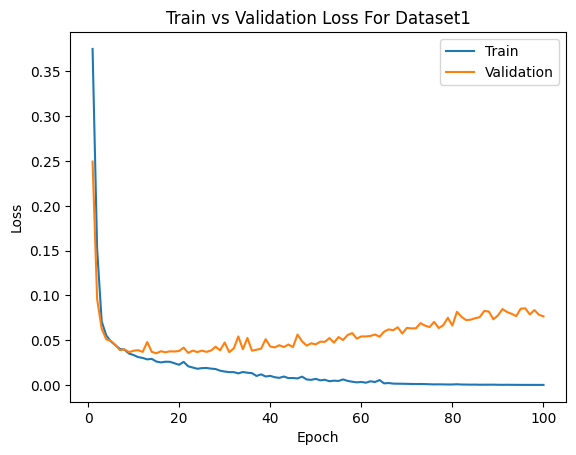

In [ ]:
plot_training_curve(get_model_name("SpamClassifier", 64, 0.01, 99,1), 1)

# Dataset 2

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)


# Define dataset path
dataset_folder = path  # This is the downloaded dataset folder

# List files in the dataset folder
files = os.listdir(dataset_folder)
print("Dataset files:", files)

# Load a CSV file into pandas
csv_file = os.path.join(dataset_folder, files[0]) # Replace with actual file name
df = pd.read_csv(csv_file, encoding='ISO-8859-1')

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\venky73\spam-mails-dataset\versions\1
Dataset files: ['spam_ham_dataset.csv']


In [ ]:
df_2 = df
df_2

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [ ]:
df_2.drop_duplicates(subset=['text'], inplace=True)
df_2.reset_index(drop=True, inplace=True)
df_2.shape

(4993, 4)

In [ ]:
# Convert labels to binary (1 for spam, 0 for non-spam)
df_2['label'] = df_2['label'].map({'ham': 0, 'spam': 1})

In [ ]:
# Remove multiple spaces
df_2['text'] = df_2['text'].str.strip()
df_2['text'] = df_2['text'].str.replace(r'\s+', ' ', regex=True)
# fix encoding issues since there are random symbols such as: â, Âº, etc.
df_2['text'] = df_2['text'].str.encode('ascii', 'ignore').str.decode('utf-8')

# removing number placeholders (&lt;#&gt)
df_2['text'] = df_2['text'].str.replace(r'&lt;#&gt;', '[NUMBER]', regex=True)

# removing URL placeholders (&lt;URL&gt;)
df_2['text'] = df_2['text'].str.replace(r'&lt;URL&gt;', '[URL]', regex=True)

# removing decimal placeholders (&lt;DECIMAL&gt;)
df_2['text'] = df_2['text'].str.replace(r'&lt;DECIMAL&gt;', '[DECIMAL]', regex=True)

# removing time placeholders (&lt;TIME&gt;)
df_2['text'] = df_2['text'].str.replace(r'&lt;TIME&gt;', '[TIME]', regex=True)

# removing email placeholders (&lt;EMAIL&gt;)
df_2['text'] = df_2['text'].str.replace(r'&lt;EMAIL&gt;', '[EMAIL]', regex=True)

# Remove all occurrences of '&gt;' (greater-than sign encoding)
df_2['text'] = df_2['text'].str.replace(r'&gt;', '', regex=True)

In [ ]:
df_2.drop(columns=['label_num'], inplace=True)
df_2.drop(columns=['Unnamed: 0'], inplace=True)
df_2


,label,text
0,0,Subject: enron methanol ; meter # : 988291 thi...
1,0,"Subject: hpl nom for january 9 , 2001 ( see at..."
2,0,"Subject: neon retreat ho ho ho , we ' re aroun..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs this deal is to b...
...,...,...
4988,0,"Subject: fw : crosstex energy , driscoll ranch..."
4989,0,Subject: put the 10 on the ft the transport vo...
4990,0,Subject: 3 / 4 / 2000 and following noms hpl c...
4991,0,Subject: industrial worksheets for august 2000...


512


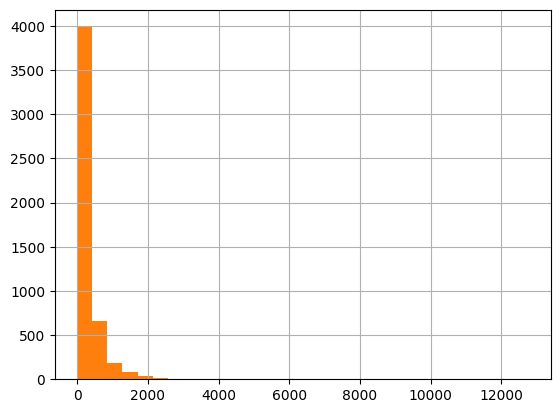

In [ ]:
#Find max sequence length
labels = df_2.iloc[:, 0].values  # Extract the first column (labels)
texts = df_2.iloc[:, 1].values   # Extract the second column (text)
max_length2 = find_max_squence_length(texts)
print(find_max_squence_length(texts))

In [ ]:
#Tokenizing function 2
text_chunks_labels2, text_embeddings2, chunk_num2 = get_embeddings_and_labels(texts,labels, max_length2)

In [ ]:
training_validation_text_embeddings2 = text_embeddings2[:11609]
training_validation_chunks_labels2 = text_chunks_labels2[:11609]
training_validation_chunks = [torch.tensor(item) for item in chunk_num2[:11609]]
print(len( text_embeddings2))


12899


In [ ]:
features2 = featuresgetter(training_validation_text_embeddings2)

In [ ]:
training_features2 = features2[:10319]
validation_features2 = features2[10319:11609]
labels2 = [torch.tensor(item).unsqueeze(0) for item in training_validation_chunks_labels2]
training_labels2 = labels2[:10319]
validation_labels2 = labels2[10319:11609]
training_chunks2 = training_validation_chunks[:10319]
validation_chunks2 = training_validation_chunks[10319:11609]

In [ ]:
train_set2 = dataset(training_features2, training_labels2, training_chunks2)
validation_set2 = dataset(validation_features2, validation_labels2, validation_chunks2)

In [ ]:
test_text_embeddings2 = text_embeddings2[11609:]
test_chunks_labels2 = text_chunks_labels2[11609:]
test_features2 = featuresgetter(test_text_embeddings2)

In [ ]:
test_chunknum2 = [torch.tensor(item) for item in chunk_num2[11609:]]

In [ ]:
print([x.tolist() for x in test_chunknum2])

In [ ]:
test_labels2 = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels2]
test_set2 = dataset(test_features2, test_labels2, test_chunknum2)

In [ ]:
spam_classifier_dataset2 = SModel()

In [ ]:
train(spam_classifier_dataset2, train_set2, validation_set2, 2, batch_size = 64)

Epoch 1: Train err: 0.23839519333268727, Train loss: 0.4836923746783056 |Validation err: 0.15891472868217055, Validation loss: 0.3358910083770752
Epoch 2: Train err: 0.0909971896501599, Train loss: 0.22160330331987804 |Validation err: 0.08062015503875969, Validation loss: 0.21715515000479563
Epoch 3: Train err: 0.0651225893981975, Train loss: 0.1704422601579148 |Validation err: 0.07054263565891473, Validation loss: 0.18680157370510556
Epoch 4: Train err: 0.0615369706366896, Train loss: 0.157349286141035 |Validation err: 0.06899224806201551, Validation loss: 0.17028731994685672
Epoch 5: Train err: 0.05630390541719159, Train loss: 0.14321379463567777 |Validation err: 0.06046511627906977, Validation loss: 0.15528281813576109
Epoch 6: Train err: 0.05310592111638725, Train loss: 0.13695729314637037 |Validation err: 0.06899224806201551, Validation loss: 0.18329684258926482
Epoch 7: Train err: 0.05155538327357302, Train loss: 0.13193120646439951 |Validation err: 0.05891472868217054, Validatio

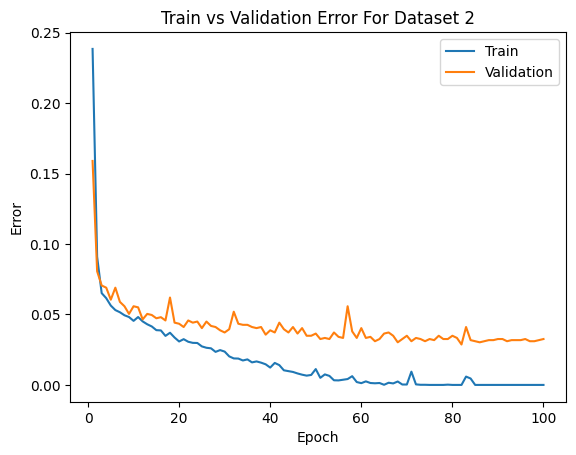

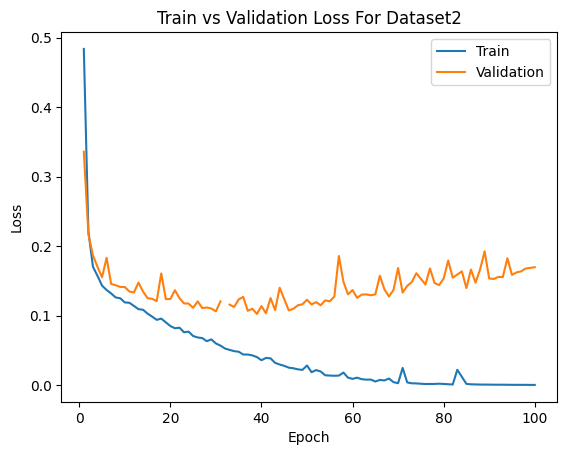

In [ ]:
plot_training_curve(get_model_name("SpamClassifier", 64, 0.01,99,2), 2)

In [ ]:
#Resources used: https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/
class SModel_withdropout(nn.Module):
    def __init__(self, kernel1 = 10, kernel2 = 15):
        super(SModel_withdropout, self).__init__()
        self.name = "SpamClassifier_withdropout"
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,1)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
#Defining spam classifier
spam_classifier_withdropout = SModel_withdropout()

In [ ]:
train(spam_classifier_withdropout, train_set, validation_set, 1)
plot_training_curve(get_model_name("SpamClassifier_withdropout", 64, 0.01, 99,1))

In [ ]:
spam_classifier_withdropout = SModel_withdropout()
train(spam_classifier_withdropout, train_set2, validation_set2, 2, batch_size = 64)
plot_training_curve(get_model_name("SpamClassifier_withdropout", 64, 0.01,99,2))

# Testing


In [ ]:
#Testing 1
spam_classifier = SModel()
model_path = get_model_name("SpamClassifier", 64, 0.01,99,1)
state1 = torch.load(model_path)
spam_classifier.load_state_dict(state1)
criterion = nn.CrossEntropyLoss()
#test_features = features
#test_labels = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels]
test_set = dataset(test_features, test_labels, test_chunknum)
test_loader = DataLoader(test_set, batch_size= 64, shuffle = True)
test_err, test_loss, predictions_list1, true_labels_list1 = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))


test error: 0.012367491166077738
test accruacy: 0.9876325088339223


In [ ]:
#Testing 2
spam_classifier = SModel()
model_path = get_model_name("SpamClassifier", 64, 0.01,99,2)
state2 = torch.load(model_path)
spam_classifier.load_state_dict(state2)
criterion = nn.CrossEntropyLoss()
#test_labels2 = [torch.tensor(item).unsqueeze(0) for item in test_chunks_labels2]
#test_set2 = dataset(test_features2, test_labels2)
test_loader = DataLoader(test_set2, batch_size = 64, shuffle = True)
test_err, test_loss, predictions_list2, true_labels_list2  = evaluate_test(spam_classifier, test_loader, criterion)
print((f"test error: {test_err}"))
print((f"test accruacy: {1-test_err}"))

test error: 0.04263565891472868
test accruacy: 0.9573643410852714


# Confusion Matrix


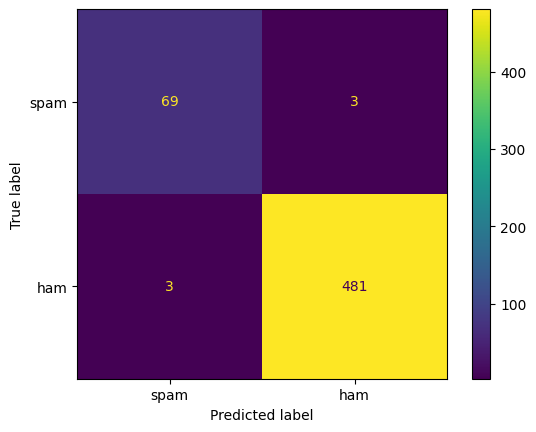

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list1, predictions_list1, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset1.png')
plt.show()

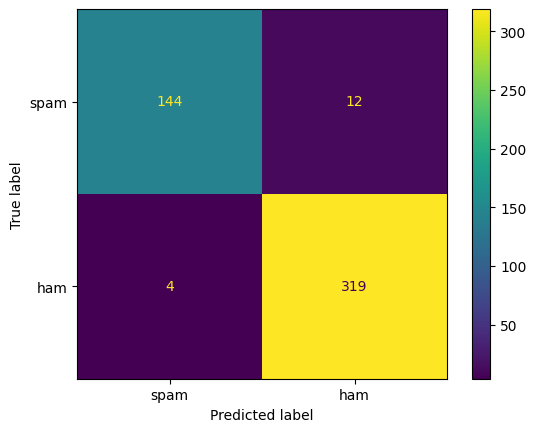

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels_list2, predictions_list2, labels = [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["spam", "ham"])
disp.plot()
plt.savefig('confusionmatrix_for_dataset2.png')
plt.show()